
**Partimos del notebook 07-08-09-10 try to improve mask segmentation with new backgroud dataset**

El problema que he detectado (puede que este equivocado) es que el fondo es el mismo en todas las imagenes, entonces entrenar una maskara con Carvana Cars dataset para predecir la maskara en el dataset de Santford Cars, no funciona bien(aun aplicando augmentación...) en mi opinion lo unico que queda es añadir un nuevo background.

En este notebook hemos encontrado un nuevo dataset llamado intel image classification, y tiene fotos de edificios y de calles, lo cual nos puede servir para cambiar el fondo de nuestros coches y probar cosas nuevas...

Vamos a probarlos


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

import numpy as np
import pandas as pd
import os
from skimage.transform import resize
from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img
from skimage.io import imread, imshow #, concatenate_images
import PIL 
from PIL import Image
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

['carvana-image-masking-challenge', 'manualdraw', 'intel-image-classification', 'stanford-car-dataset-by-classes-folder']


Using TensorFlow backend.


Preparamos unas cuantas funciones para leer del directorio

In [2]:
!ls '../input/intel-image-classification/seg_train/seg_train/buildings/'

0.jpg	   12561.jpg  14916.jpg  17468.jpg  20017.jpg  4598.jpg  7382.jpg
10006.jpg  12578.jpg  14918.jpg  17479.jpg  2002.jpg   4600.jpg  7383.jpg
1001.jpg   12590.jpg  14947.jpg  17480.jpg  20027.jpg  4620.jpg  739.jpg
10014.jpg  12602.jpg  14952.jpg  17491.jpg  20048.jpg  4621.jpg  7418.jpg
10018.jpg  12615.jpg  14958.jpg  17495.jpg  20054.jpg  4623.jpg  742.jpg
10029.jpg  12617.jpg  14968.jpg  17503.jpg  2038.jpg   463.jpg	 7439.jpg
10032.jpg  12629.jpg  14984.jpg  1751.jpg   2041.jpg   4630.jpg  7443.jpg
10056.jpg  1263.jpg   14991.jpg  17516.jpg  2043.jpg   4631.jpg  7455.jpg
1009.jpg   12632.jpg  1501.jpg	 17520.jpg  2059.jpg   4634.jpg  7463.jpg
10113.jpg  12636.jpg  15026.jpg  1753.jpg   2069.jpg   4667.jpg  747.jpg
1012.jpg   12649.jpg  1503.jpg	 17537.jpg  2076.jpg   4686.jpg  7471.jpg
10126.jpg  12659.jpg  15030.jpg  17539.jpg  2083.jpg   47.jpg	 7478.jpg
10144.jpg  12668.jpg  15042.jpg  17541.jpg  2088.jpg   4715.jpg  749.jpg
10151.jpg  12669.jpg  15045.jpg  17545.jpg  2099.

In [3]:
!ls '../input/intel-image-classification/seg_train/seg_train/buildings/'

0.jpg	   12561.jpg  14916.jpg  17468.jpg  20017.jpg  4598.jpg  7382.jpg
10006.jpg  12578.jpg  14918.jpg  17479.jpg  2002.jpg   4600.jpg  7383.jpg
1001.jpg   12590.jpg  14947.jpg  17480.jpg  20027.jpg  4620.jpg  739.jpg
10014.jpg  12602.jpg  14952.jpg  17491.jpg  20048.jpg  4621.jpg  7418.jpg
10018.jpg  12615.jpg  14958.jpg  17495.jpg  20054.jpg  4623.jpg  742.jpg
10029.jpg  12617.jpg  14968.jpg  17503.jpg  2038.jpg   463.jpg	 7439.jpg
10032.jpg  12629.jpg  14984.jpg  1751.jpg   2041.jpg   4630.jpg  7443.jpg
10056.jpg  1263.jpg   14991.jpg  17516.jpg  2043.jpg   4631.jpg  7455.jpg
1009.jpg   12632.jpg  1501.jpg	 17520.jpg  2059.jpg   4634.jpg  7463.jpg
10113.jpg  12636.jpg  15026.jpg  1753.jpg   2069.jpg   4667.jpg  747.jpg
1012.jpg   12649.jpg  1503.jpg	 17537.jpg  2076.jpg   4686.jpg  7471.jpg
10126.jpg  12659.jpg  15030.jpg  17539.jpg  2083.jpg   47.jpg	 7478.jpg
10144.jpg  12668.jpg  15042.jpg  17541.jpg  2088.jpg   4715.jpg  749.jpg
10151.jpg  12669.jpg  15045.jpg  17545.jpg  2099.

In [4]:
def intel_files_names_in_path(path="",extension=".jpg"):
    files = []
    
    for f in os.listdir(path):
        filename, file_extension = os.path.splitext(f)
        if file_extension == '.jpg':
            files.append(path+filename+".jpg")
    
            
    return files

building = '../input/intel-image-classification/seg_train/seg_train/buildings/'
street = '../input/intel-image-classification/seg_train/seg_train/street/'
background_path = intel_files_names_in_path(street)
background_path.append(intel_files_names_in_path(building))


(150, 150, 3)


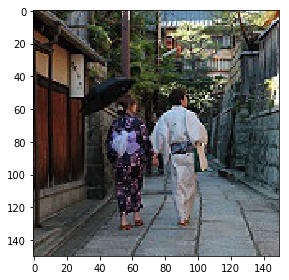

In [5]:
img1=imread(background_path[290])
print(img1.shape)
imshow(img1)

In [6]:
!ls '../input/carvana-image-masking-challenge/train_masks/'

00087a6bd4dc_01_mask.gif  4df1536de792_01_mask.gif  a7b9e343cf6b_01_mask.gif
00087a6bd4dc_02_mask.gif  4df1536de792_02_mask.gif  a7b9e343cf6b_02_mask.gif
00087a6bd4dc_03_mask.gif  4df1536de792_03_mask.gif  a7b9e343cf6b_03_mask.gif
00087a6bd4dc_04_mask.gif  4df1536de792_04_mask.gif  a7b9e343cf6b_04_mask.gif
00087a6bd4dc_05_mask.gif  4df1536de792_05_mask.gif  a7b9e343cf6b_05_mask.gif
00087a6bd4dc_06_mask.gif  4df1536de792_06_mask.gif  a7b9e343cf6b_06_mask.gif
00087a6bd4dc_07_mask.gif  4df1536de792_07_mask.gif  a7b9e343cf6b_07_mask.gif
00087a6bd4dc_08_mask.gif  4df1536de792_08_mask.gif  a7b9e343cf6b_08_mask.gif
00087a6bd4dc_09_mask.gif  4df1536de792_09_mask.gif  a7b9e343cf6b_09_mask.gif
00087a6bd4dc_10_mask.gif  4df1536de792_10_mask.gif  a7b9e343cf6b_10_mask.gif
00087a6bd4dc_11_mask.gif  4df1536de792_11_mask.gif  a7b9e343cf6b_11_mask.gif
00087a6bd4dc_12_mask.gif  4df1536de792_12_mask.gif  a7b9e343cf6b_12_mask.gif
00087a6bd4dc_13_mask.gif  4df1536de792_13_mask.gif  a7b9e343cf6b_13_mask.gif

In [7]:
def files_names_in_path_carvana(path="",extension=".jpg"):
    files = []
    masks = []
    for f in os.listdir(path):
        filename, file_extension = os.path.splitext(f)
        if file_extension == '.gif':
            files.append(filename.replace('_mask','')+".jpg")
            masks.append(filename+".gif")
            
    return files, masks


car_path = '../input/carvana-image-masking-challenge/train/'
mask_path = '../input/carvana-image-masking-challenge/train_masks/'
input_files,input_masks = files_names_in_path_carvana(mask_path)

print(input_files[0:5])
print(input_masks[0:5])



['4b74275babf7_02.jpg', '3071362591f7_04.jpg', '0495dcf27283_10.jpg', 'd1a3af34e674_01.jpg', 'fc237174b128_09.jpg']
['4b74275babf7_02_mask.gif', '3071362591f7_04_mask.gif', '0495dcf27283_10_mask.gif', 'd1a3af34e674_01_mask.gif', 'fc237174b128_09_mask.gif']


* -Tenemos buildings y street en backgroudpath
* -Tenemos coches en car_path
* -Tenemos la mascara del coche en mask_path

-Queremos 1.-Augmentar el coche y la mascara y segundo fusionarla en el fondo


In [8]:
#1.-recreamos nuestras augmentaciones copiadas de notebooks anteriores

import pylab as pl # linear algebra + plotting


# trying to add random noise
from skimage.transform import warp, AffineTransform, ProjectiveTransform
from skimage.exposure import equalize_adapthist, equalize_hist, rescale_intensity, adjust_gamma, adjust_log, adjust_sigmoid
from skimage.filters import gaussian
from skimage.util import random_noise
import random


H = 256
W = 256

def downsample(img, h, w):    
    ret = resize(img, (h, w), mode='constant', preserve_range=True)
    # plt.imshow(ret)
    return ret
    #return cv2.resize(img, (h, w))

def randRange(a, b):
    return pl.rand() * (b - a) + a

def randomPerspective(im,mask):
    
    region = 1/4
    A = pl.array([[0, 0], [0, im.shape[0]], [im.shape[1], im.shape[0]], [im.shape[1], 0]])
    B = pl.array([[int(randRange(0, im.shape[1] * region)), int(randRange(0, im.shape[0] * region))], 
                  [int(randRange(0, im.shape[1] * region)), int(randRange(im.shape[0] * (1-region), im.shape[0]))], 
                  [int(randRange(im.shape[1] * (1-region), im.shape[1])), int(randRange(im.shape[0] * (1-region), im.shape[0]))], 
                  [int(randRange(im.shape[1] * (1-region), im.shape[1])), int(randRange(0, im.shape[0] * region))], 
                 ])

    pt = ProjectiveTransform()
    pt.estimate(A, B)
    
    return warp(im, pt, output_shape=im.shape[:2]), warp(mask, pt, output_shape=im.shape[:2])


def augmentation(image, mascara):
    noise = np.random.randint(0,3)
    
    newimg = image
    newmask = mascara
    
    if noise == 1:
        #aplicamos randomroise
        var = np.random.randint(0,1000)/100000
        newimg = random_noise(image, mode='gaussian', var=var)
    elif noise == 2: 
        #applicamos gaussian noise
        newimg = gaussian(image, sigma=randRange(0, 2))
    #sino no aplicamos ruidos dejamos la original
    
    crop = np.random.randint(0,2)
    
    if crop == 1:
        #aplicamos crop
        #print("CROP")
        #newimg, newmask = randomCrop(newimg, newmask)
    #elif crop == 2:
        #print("prespective")
        newimg, newmask = randomPerspective(newimg, newmask)
        
     ## ¿Nos falta algun agumentador que canvie el color?? bueno vamos a ver que tal va este   
    return newimg, newmask
    
    
demoimage  = imread(car_path+input_files[0])/255
demomask = imread(mask_path+input_masks[0])/255
aug_demoimage, aug_demomask = augmentation(demoimage, demomask)

aug_demoimage = downsample(aug_demoimage,H,W)
aug_demomask = downsample(aug_demomask,H,W)

/opt/conda/lib/python3.6/site-packages/skimage/filters/_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


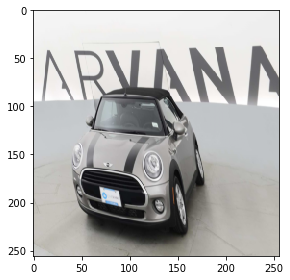

In [9]:
imshow(aug_demoimage)

1.0


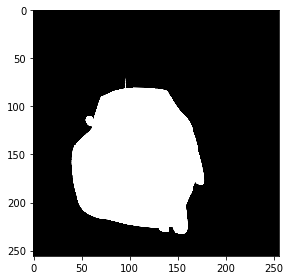

In [10]:
imshow(aug_demomask)
print(np.max(aug_demomask))

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


0.9995429543887867
(256, 256, 3)


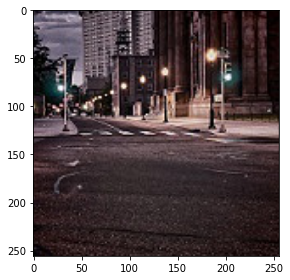

In [11]:
back_img = downsample(imread(background_path[53])/255,H,W)
imshow(back_img)
print(np.max(back_img))
print(back_img.shape)

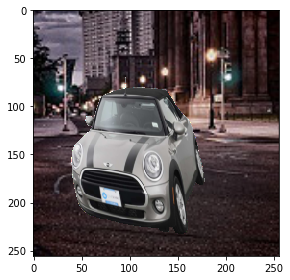

In [12]:
import cv2
#Need only car image apply bitwise 
def get_only_object(img, mask, back_img):
    fg = cv2.bitwise_or(img, img, mask=mask)        
    #imshow(fg)
    # invert mask
    mask_inv = cv2.bitwise_not(mask)    
    #fg_back = cv2.bitwise_or(back_img, back_img, mask=mask)
    fg_back_inv = cv2.bitwise_or(back_img, back_img, mask=mask_inv)
    #imshow(fg_back_inv)
    final = cv2.bitwise_or(fg, fg_back_inv)
    #imshow(final)

    return final

only_car = get_only_object(np.uint8(aug_demoimage*255), np.uint8(aug_demomask*255), np.uint8(back_img*255))/255
imshow(only_car)
